In [1]:
import atomman as am
import atomman.unitconvert as uc
import atomman.lammps as lmp
import numpy as np
from copy import deepcopy
import potentials
import datetime
import iprPy

from pathlib import Path

import matplotlib.pyplot as plt

In [40]:
class Bain():
    
    def __init__(self, a_bcc, a_fcc, symbol):
        
        # Define prototype bcc ucell
        self.__proto = am.System(atoms=am.Atoms(pos=[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]]), symbols=symbol)
        
        self.a_bcc = a_bcc
        self.a_fcc = a_fcc

    @property
    def proto(self):
        return self.__proto
        
    @property
    def a_bcc(self):
        return self.__a_bcc
    
    @a_bcc.setter
    def a_bcc(self, value):
        self.__a_bcc = float(value)
    
    @property
    def a_fcc(self):
        return self.__a_fcc
    
    @a_fcc.setter
    def a_fcc(self, value):
        self.__a_fcc = float(value)
    
    def ucell(self, a_scale, c_scale):
        
        # Get the ideal deformation points
        a_0 = self.a_fcc * 2**0.5 / 2
        c_0 = self.a_fcc
        a_1 = c_1 = self.a_bcc
        
        a = a_0 * (1 - a_scale) + a_1 * a_scale
        c = c_0 * (1 - c_scale) + c_1 * c_scale
        
        ucell = deepcopy(self.proto)
        ucell.box_set(a=a, b=a, c=c, scale=True)
        
        return ucell
    
    def itercellmap(self, num_a=23, num_c=23, min_a=-0.05, max_a=1.05, min_c=-0.05, max_c=1.05):
        
        
        # Construct mesh of regular points
        avals, cvals = np.meshgrid(np.linspace(min_a, max_a, num_a),
                                   np.linspace(min_c, max_c, num_c))
        
        for a, c in zip(avals.flat, cvals.flat):
            yield a, c, self.ucell(a, c)
            
    def set_results(self, a_scale, c_scale, E_coh):
        d = int(len(results['a_scale'])**0.5)
        
        self.a_scale = np.array(a_scale)
        self.c_scale = np.array(c_scale)
        self.E_coh = np.array(E_coh)
        
    def plot_1d_path(self):
        
        fig = plt.figure(figsize=(8,5))
        
        matches = (self.a_scale == self.c_scale)
        plt.plot(self.a_scale[matches], self.E_coh[matches])
        plt.xlabel('linear deformation coefficient: 0=fcc, 1=bcc')
        plt.ylabel('Cohesive energy (eV/atom)')
        
        return fig
    
    def plot_2d(self):
        
        fig = plt.figure(figsize=(10,8))
        
        d = int(len(self.a_scale.flat)**0.5)
        a_scale = self.a_scale.reshape(d,d)
        c_scale = self.c_scale.reshape(d,d)
        E_coh = self.E_coh.reshape(d,d)
        plt.pcolormesh(a_scale, c_scale, E_coh)
        plt.xlabel('xy linear deformation coefficient')
        plt.xlabel('z linear deformation coefficient')
        cbar = plt.colorbar()
        cbar.ax.set_ylabel('cohesive energy (eV/atom)',
                           fontsize='x-large')
        plt.show()
        
        return fig
    

In [3]:
with open('min.template', 'w') as f:
    f.write("""#LAMMPS input script that performs a simple energy minimization

<atomman_system_pair_info>

thermo_style custom step lx ly lz pxx pyy pzz pe
thermo_modify format float %.13e

compute peatom all pe/atom 

min_modify dmax <dmax>

dump dumpit all custom <maxeval> <sim_directory>*.dump id type x y z c_peatom
dump_modify dumpit format <dump_modify_format>
minimize <etol> <ftol> <maxiter> <maxeval>""")

In [9]:
def baintransformation(a_bcc, a_fcc, symbol, sizemults, potential, lammps_command, mpi_command=None,
                       num_a=23, num_c=23, min_a=-0.05, max_a=1.05, min_c=-0.05, max_c=1.05,
                       etol=0.0, ftol=1e-6, maxiter=100000, maxeval=100000,
                       dmax=uc.set_in_units(0.01, 'angstrom')):
    
    # Build filedict if function was called from iprPy
    try:
        assert __name__ == pkg_name
        calc = iprPy.load_calculation(calculation_style)
        filedict = calc.filedict
    except:
        filedict = {}
    
    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
    
    # Get lammps version date
    lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Get lammps template
    template_file = 'min.template'
    template = iprPy.tools.read_calc_file(template_file, filedict)
    
    # Define constant lammps variables
    lammps_variables = {}
    lammps_variables['etol'] = etol
    lammps_variables['ftol'] = uc.get_in_units(ftol, lammps_units['force'])
    lammps_variables['maxiter'] = maxiter
    lammps_variables['maxeval'] = maxeval
    lammps_variables['dmax'] = uc.get_in_units(dmax, lammps_units['length'])
    
    # Set dump_modify format based on dump_modify_version
    if lammps_date < datetime.date(2016, 8, 3):
        lammps_variables['dump_modify_format'] = '"%i %i %.13e %.13e %.13e %.13e"'
    else:
        lammps_variables['dump_modify_format'] = 'float %.13e'
    
    # Define bain object
    bain = Bain(a_bcc=a_bcc, a_fcc=a_fcc, symbol=symbol)
    
    energies = []
    a_scales = []
    c_scales = []
    i = 0
    # Iterate over cells
    for a_scale, c_scale, ucell in bain.itercellmap(num_a=num_a, num_c=num_c, min_a=min_a,
                                                   max_a=max_a, min_c=min_c, max_c=max_c):
    
        system = ucell.supersize(*sizemults)
    
        sim_directory = Path(str(i))
        if not sim_directory.is_dir():
            sim_directory.mkdir()
        sim_directory = sim_directory.as_posix()+'/'
            
        # Define lammps variables
        system_info = system.dump('atom_data', f=Path(sim_directory, 'atom.dat').as_posix(),
                                  potential=potential,
                                  return_pair_info=True)
        lammps_variables['atomman_system_pair_info'] = system_info
        lammps_variables['sim_directory'] = sim_directory
        
        # Write lammps input script
        lammps_script = Path(sim_directory, 'min.in')
        with open(lammps_script, 'w') as f:
            f.write(iprPy.tools.filltemplate(template, lammps_variables,
                                             '<', '>'))
        # Run LAMMPS
        output = lmp.run(lammps_command, lammps_script.as_posix(), mpi_command,
                         logfile=Path(sim_directory, 'log.lammps').as_posix())

        # Extract output values
        thermo = output.simulations[-1]['thermo']
        E_total = uc.set_in_units(thermo.PotEng.values[-1],
                                  lammps_units['energy'])
        a_scales.append(a_scale)
        c_scales.append(c_scale)
        energies.append(E_total / system.natoms)
        
        i += 1
    
    # Return results
    results_dict = {}
    results_dict['a_scale'] = a_scales
    results_dict['c_scale'] = c_scales
    results_dict['E_coh'] = energies
    
    return results_dict

In [10]:
a_bcc=2.8665
a_fcc=3.6057

In [11]:
potdb = potentials.Database(localpath='C:/Users/lmh1/Documents/library')
potential = potdb.get_lammps_potential(id='2006--Chamati-H--Fe--LAMMPS--ipr1')

In [12]:
results = baintransformation(a_bcc, a_fcc, 'Fe', (3, 3, 3), potential, 'lmp_mpi')

In [13]:
results

{'a_scale': [-0.05,
  0.0,
  0.05,
  0.10000000000000002,
  0.15000000000000002,
  0.2,
  0.25000000000000006,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95,
  1.0,
  1.05,
  -0.05,
  0.0,
  0.05,
  0.10000000000000002,
  0.15000000000000002,
  0.2,
  0.25000000000000006,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95,
  1.0,
  1.05,
  -0.05,
  0.0,
  0.05,
  0.10000000000000002,
  0.15000000000000002,
  0.2,
  0.25000000000000006,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95,
  1.0,
  1.05,
  -0.05,
  0.0,
  0.05,
  0.10000000000000002,
  0.15000000000000002,
  0.2,
  0.25000000000000006,
  0.30000000000000004,
  0.35000000000000003,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95,


In [41]:
bain = Bain(a_bcc=a_bcc, a_fcc=a_fcc, symbol='Fe')
bain.set_results(**results)

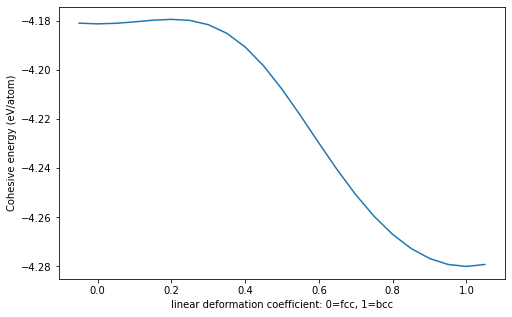

In [42]:
bain.plot_1d_path()
plt.show()

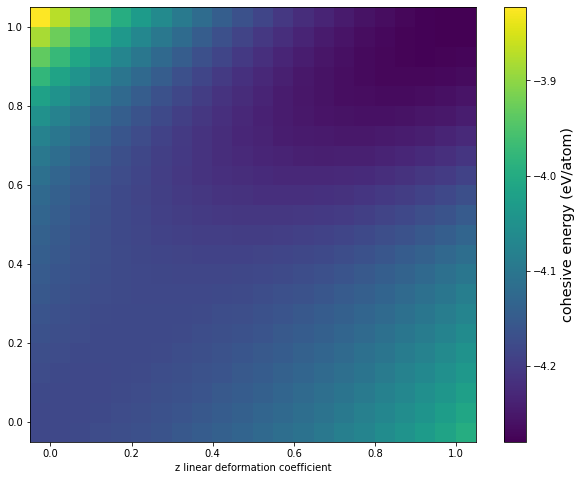

In [43]:
bain.plot_2d()
plt.show()